In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
import seaborn as sns


ModuleNotFoundError: No module named 'seaborn'

In [11]:
def squared_hinge_loss(w, X, y, C):
    margins = 1 - y * (X @ w)
    return 0.5 * np.dot(w, w) + C * np.sum(np.maximum(0, margins)**2)

def squared_hinge_grad(w, X, y, C):
    margins = 1 - y * (X @ w)
    indicator = margins > 0
    grad = -2 * C * (X.T @ (y * margins * indicator))
    return w + grad

# gradient descent
def gradient_descent(X, y, C, max_iter=200, tol=1e-5):
    w = np.zeros(X.shape[1])
    losses = []
    start = time.time()
    for _ in range(max_iter):
        grad = squared_hinge_grad(w, X, y, C)
        step = 1.0
        while squared_hinge_loss(w - step * grad, X, y, C) > squared_hinge_loss(w, X, y, C) - 0.5 * step * np.linalg.norm(grad)**2:
            step *= 0.5
        w -= step * grad
        loss = squared_hinge_loss(w, X, y, C)
        losses.append(loss)
        if np.linalg.norm(grad) < tol:
            break
    duration = time.time() - start
    return w, losses, duration

# LBFGS
def solve_lbfgs(X, y, C):
    counter = {'nfev': 0}
    def f(w):
        counter['nfev'] += 1
        return squared_hinge_loss(w, X, y, C)
    def grad(w):
        return squared_hinge_grad(w, X, y, C)
    start = time.time()
    result = minimize(f, np.zeros(X.shape[1]), jac=grad, method='L-BFGS-B')
    duration = time.time() - start
    return result.x, result.fun, result.nfev, duration

# coordinate descent
def coordinate_descent(X, y, C, max_iter=100):
    n, d = X.shape
    w = np.zeros(d)
    start = time.time()

    for it in range(max_iter):
        for j in range(d):
            
            margins = 1 - y * (X @ w)
            indicator = margins > 0

            grad_j = w[j] - 2 * C * np.sum(y * margins * indicator * X[:, j])
            grad_j = np.clip(grad_j, -10, 10)

            w[j] -= 0.01 * grad_j

        full_grad = squared_hinge_grad(w, X, y, C)
        if np.linalg.norm(full_grad) < 1e-5:
            break

    duration = time.time() - start
    loss = squared_hinge_loss(w, X, y, C)
    return w, loss, duration


class SquaredHingeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, solver='lbfgs'):
        self.C = C
        self.solver = solver

    def fit(self, X, y):
        self.classes_ = np.unique(y)  
        if self.solver == 'lbfgs':
            self.w, _, _, _ = solve_lbfgs(X, y, self.C)
        elif self.solver == 'gd':
            self.w, _, _ = gradient_descent(X, y, self.C)
        elif self.solver == 'cd':
            self.w, _, _ = coordinate_descent(X, y, self.C)
        return self

    def predict(self, X):
        return np.sign(X @ self.w)

    def decision_function(self, X):
        return X @ self.w


In [12]:
X, y = make_classification(n_samples=2000, n_features=30, n_informative=20,
                           n_redundant=10, n_classes=2, random_state=42)
y = 2 * y - 1
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [13]:
from sklearn.datasets import load_breast_cancer


data = load_breast_cancer()
X = data.data
y = data.target
y = 2 * y - 1  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)


Running GridSearchCV for solver: gd

Running GridSearchCV for solver: lbfgs

Running GridSearchCV for solver: cd


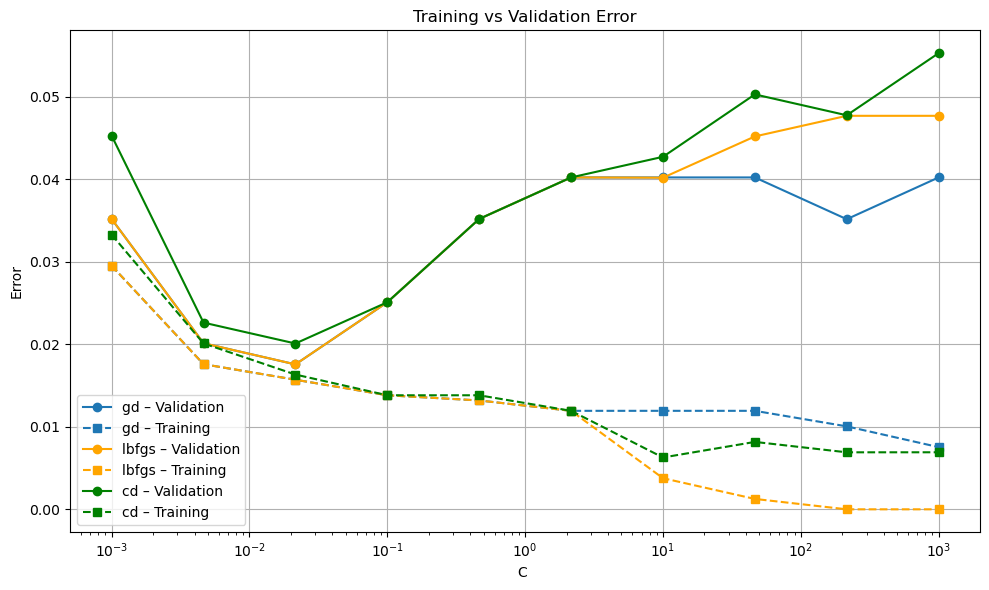

In [ ]:
param_grid = {'C': np.logspace(-3, 3, 10)}
solvers = ['gd', 'lbfgs', 'cd']
cv_results = {}
results = {}


for solver in solvers:
    print(f"\nRunning GridSearchCV for solver: {solver}")
    
    try:
        clf = SquaredHingeClassifier(solver=solver)
        gs = GridSearchCV(
            clf,
            param_grid,
            cv=5,
            scoring='accuracy',
            return_train_score=True,
            error_score='raise'
        )

        start = time.time()
        gs.fit(X_train, y_train)
        duration = time.time() - start

        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)

        
        if np.any(np.isnan(y_pred)):
            raise ValueError("NaN detected in predictions.")

        cv_results[solver] = gs

        results[solver] = {
            'best_C': gs.best_params_['C'],
            'accuracy': accuracy_score(y_test, y_pred),
            'conf_matrix': confusion_matrix(y_test, y_pred),
            'cpu_time': duration
        }

    except Exception as e:
        print(f" Solver '{solver}' failed: {e}")
        results[solver] = {'error': str(e)}


plt.figure(figsize=(10, 6))

for solver in solvers:
    if solver in cv_results:
        gs = cv_results[solver]
        mean_val_error = 1 - gs.cv_results_['mean_test_score']
        mean_train_error = 1 - gs.cv_results_['mean_train_score']
        Cs = param_grid['C']

        
        colour_map = {
            'gd'   : 'C0',      
            'lbfgs': 'orange',
            'cd'   : 'green'
        }

        plt.semilogx(
            Cs,
            mean_val_error,
            marker='o',
            label=f'{solver} – Validation',
            color=colour_map.get(solver, 'black')   
        )

        plt.semilogx(
        Cs,
        mean_train_error,
        marker='s',
        linestyle='--',
        label=f'{solver} – Training',
        color=colour_map.get(solver, 'black')
    )
plt.xlabel("C ")
plt.ylabel("Error")
plt.title("Training vs Validation Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:

solvers = ['gd', 'lbfgs', 'cd']
final_results = {}

for solver in solvers:
    print(f"Evaluating solver: {solver}")
    best_C = results[solver]['best_C']
    clf = SquaredHingeClassifier(C=best_C, solver=solver)
    
    try:
        start = time.time()
        clf.fit(X_train, y_train)
        duration = time.time() - start
        
        y_pred = clf.predict(X_test)
        final_results[solver] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, clf.decision_function(X_test)),
            'norm_w': np.linalg.norm(clf.w),
            'cpu_time': duration,
            'conf_matrix': confusion_matrix(y_test, y_pred)
        }
    except Exception as e:
        print(f"Solver {solver} failed: {e}")


Evaluating solver: gd
Evaluating solver: lbfgs
Evaluating solver: cd
